# Density evaluation

In [1]:
# import libraries
import sklearn
import pandas as pd
import numpy as np
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

# Loading dataset

In [2]:
dataset_path='C:/Users/miche/Desktop/anemia-detection/database_sclere/'   # modify the dataset_path to your own dir
assert dataset_path!='' and dataset_path!='/path/to/dataset/', 'Please specify the dataset_path!'

# load csv file
df = pd.read_csv(dataset_path+'hbvalue.csv', sep=';')

# cut the dataset only to ind and ita dataset
df = df[(df['dataset']=='ind') | (df['dataset']=='ita')]

df.head()


,dataset,paziente,foto1,foto2,hb,Nome Cognome,Sesso,Et?,Data Nascita,buona,Unnamed: 10
0,ita,T_1,92317,92247,"14,1",Caterina Antonacci,F,40,1979.0,NaN,NaN
1,ita,T_2,93707,93702,"13,9",Maria Campobasso,F,34,1985.0,NaN,NaN
2,ita,T_3,94015,94012,"14,1",Vitangelo Lops,M,53,1966.0,NaN,NaN
3,ita,T_4,95329,95326,"15,7",Maro Mahdal,M,36,1983.0,NaN,NaN
4,ita,T_5,74439,74432,"13,9",Giuseppe Rosario Barile,M,51,1968.0,NaN,NaN


# Loading photos

In [3]:
path_photos = dataset_path+'Dataset indiano/'
sclera_vessels = []
sclera_masks = []
sclera_cielabs = []

# cicla sul dataset indiano
for index, row in tqdm(df.iterrows(), total=df.shape[0]):

    if row['dataset'] == 'ind':
        path_photos = dataset_path+'Dataset indiano/'
        paziente = row['paziente'] + "-"
    else:
        path_photos = dataset_path+'Italiano congiuntive/Dataset congiuntive italiano segmentato/'
        paziente = row['paziente'] + "_"

    # search folder
    matching_folders = []
    for folder_name in os.listdir(path_photos):
        if folder_name.startswith(paziente) and os.path.isdir(os.path.join(path_photos, folder_name)):
            path_single_photo = os.path.join(path_photos, folder_name)

            name_photo = folder_name.split("-")[-1]
            # load sclera
            sclera_mask = cv2.imread(path_single_photo + "/" + name_photo + '_sclera.png')
            sclera_masks.append(sclera_mask)

            # converts to cielab
            sclera_cielab = cv2.cvtColor(sclera_mask, cv2.COLOR_BGR2LAB)
            sclera_cielabs.append(sclera_cielab)

            # load mask
            sclera_vessel = cv2.imread(path_single_photo + "/" + name_photo + '_sclera_vessels_auto_deep2.png', cv2.IMREAD_UNCHANGED)
            
            if sclera_vessel is None:
                sclera_vessel = cv2.imread(path_single_photo + "/" + name_photo + '_sclera_vessels_auto_deep.png', cv2.IMREAD_UNCHANGED)

                if sclera_vessel is None:
                    sclera_vessel = cv2.imread(path_single_photo + "/" + name_photo + '_sclera_vessels_auto.png', cv2.IMREAD_UNCHANGED)
            
            sclera_vessels.append(sclera_vessel)
            break



100%|██████████| 186/186 [00:37<00:00,  4.90it/s]


# Preprocessing

100%|██████████| 186/186 [00:01<00:00, 156.54it/s]


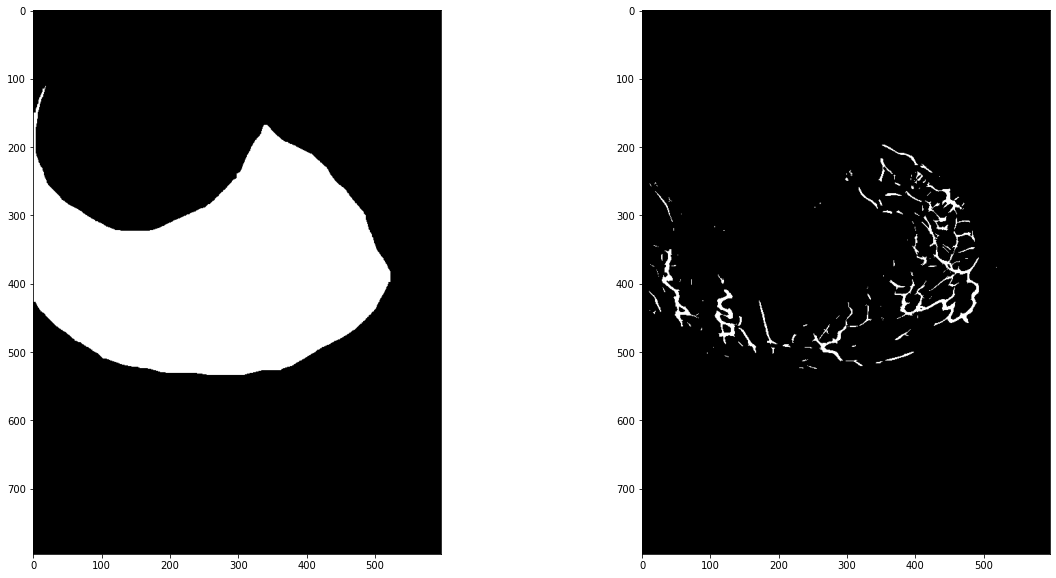

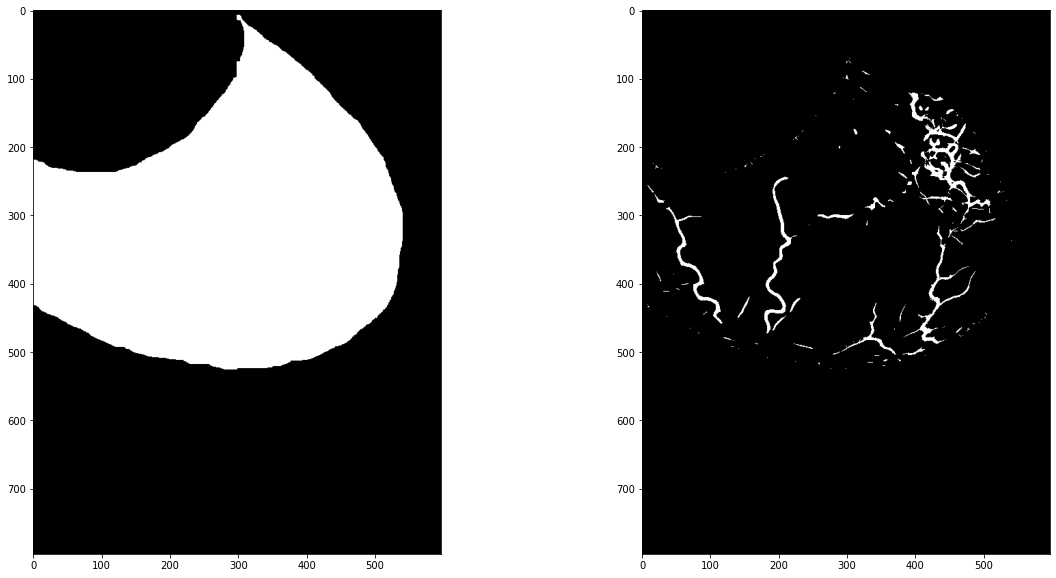

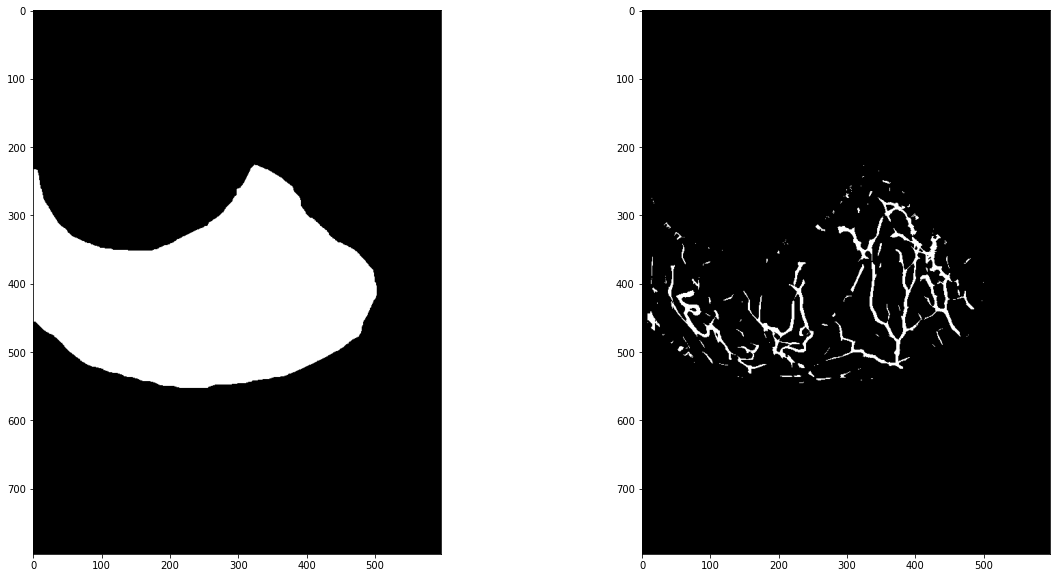

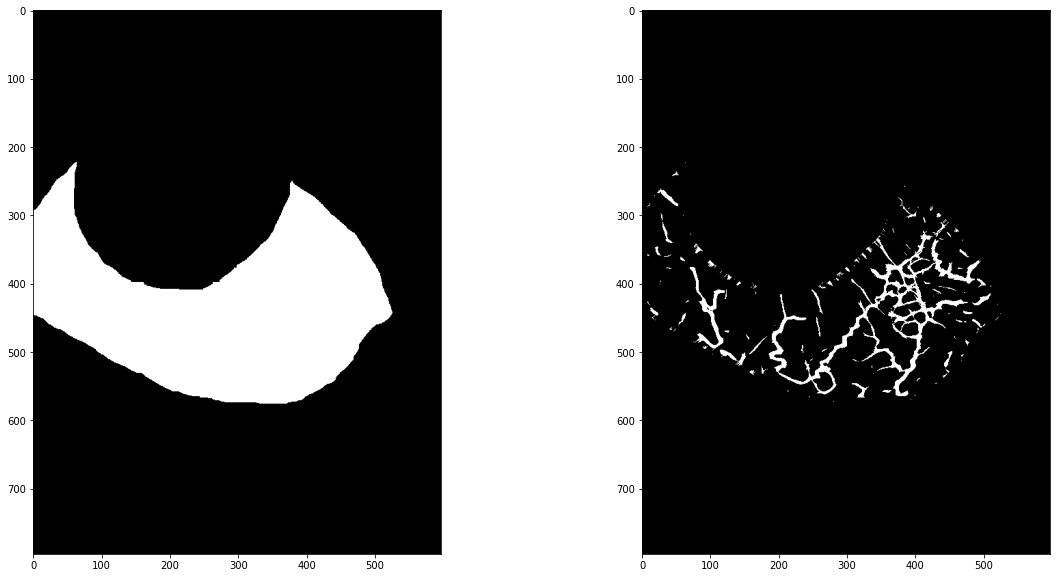

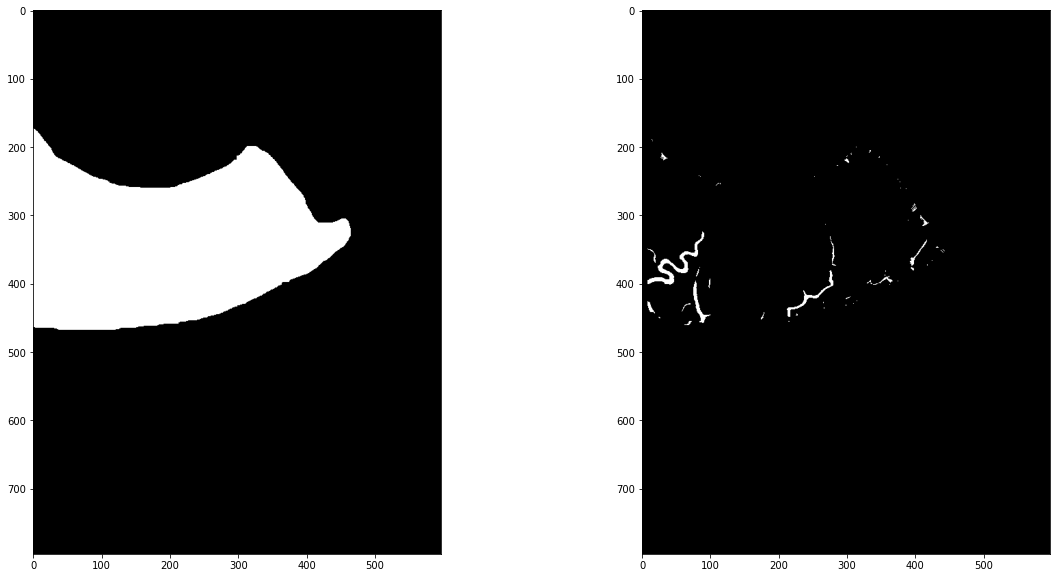

In [4]:
sclera_vessels_shape = sclera_vessels[0].shape

# converts the sclera masks to black and white
for index, mask in tqdm(enumerate(sclera_masks), total=len(sclera_masks)):
    # resize the mask to the sclera vessel shape
    mask = cv2.resize(mask, sclera_vessels_shape[:2][::-1])
    
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    
    _, mask = cv2.threshold(mask, 2, 255, cv2.THRESH_BINARY)

    sclera_masks[index] = mask

# converts the sclera vessels to black and white
for index, mask in tqdm(enumerate(sclera_vessels), total=len(sclera_vessels)):
    # transparence becomes black
    mask[mask[:, :, 3] == 0] = [0, 0, 0, 0]
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    
    _, mask = cv2.threshold(mask, 2, 255, cv2.THRESH_BINARY)
    
    sclera_vessels[index] = mask


# show the sclera masks and sclera vessels
for i in range(5):
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(sclera_masks[i], cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(sclera_vessels[i], cmap='gray')
    plt.show()

In [5]:
def increase_contrast_lab(image_lab):
    image_lab[:, :, 1] = cv2.multiply(image_lab[:, :, 1], 1.2)

    return image_lab

for index, image in tqdm(enumerate(sclera_cielabs), total=len(sclera_cielabs)):

    # Applica l'equalizzazione dell'istogramma adattivo a tutti i canali (L, a, b) dell'immagine Lab
    clahe = cv2.createCLAHE(clipLimit=1.82, tileGridSize=(8, 8))
    image_lab_eq = image.copy()
    for i in range(3):
        image_lab_eq[:, :, i] = clahe.apply(image_lab_eq[:, :, i])

    # Applica il contrasto all'immagine Lab
    image_lab_eq = increase_contrast_lab(image_lab_eq)

    sclera_cielabs[index] = image_lab_eq
    


100%|██████████| 186/186 [00:25<00:00,  7.43it/s]


# Density calculation

In [6]:
def energy_fourier_transform(image, n = 4):
    
    # Applica la trasformata di Fourier
    frequencies = np.fft.fft2(image)

    # Sposta l'origine al centro dell'immagine
    frequencies_shifted = np.fft.fftshift(frequencies)

    # Calcola il modulo dei coefficienti di Fourier
    magnitudes = np.abs(frequencies_shifted)

    # Dividi l'immagine in bande di frequenza
    bands = np.split(magnitudes, n)  # n è il numero di bande desiderate

    # Calcola l'energia di ciascuna banda
    energies = [np.sum(np.square(band)) for band in bands]

    return energies

In [7]:
# calculate the density of the vessels in the sclera
vessels_density = []
for index, mask in tqdm(enumerate(sclera_masks), total=len(sclera_masks)):
    
    vessels_volume = cv2.countNonZero(sclera_vessels[index])
    sclera_volume = cv2.countNonZero(mask)

    densita = vessels_volume / sclera_volume
    vessels_density.append(densita)
    
# calculate the density of the color of vessels in the sclera
vessels_colors_density = []
vessels_colors_quantiles = []
vessels_colors_density_rgb = []
vessels_colors_deviations = []
vessels_fourier_energies = []
for index, mask in tqdm(enumerate(sclera_vessels), total=len(sclera_vessels)):
    
    cielab = sclera_cielabs[index]

    mask =  cv2.resize(mask, cielab.shape[:2][::-1])

    # converts to rgb
    cielab_rgb = cv2.cvtColor(cielab, cv2.COLOR_LAB2BGR)
    cielab_rgb = cv2.cvtColor(cielab_rgb, cv2.COLOR_BGR2RGB)

    # moltiplica la maschera per le sclere con i colori
    cielab = cv2.bitwise_and(cielab, cielab, mask=mask)
    cielab_rgb = cv2.bitwise_and(cielab_rgb, cielab_rgb, mask=mask)
    
    # calcola la densità dei colori
    densita = cv2.mean(cielab, mask=mask)
    densita_rgb = cv2.mean(cielab_rgb, mask=mask)
    vessels_colors_density.append(densita)
    vessels_colors_density_rgb.append(densita_rgb)

    std = cv2.meanStdDev(cielab, mask=mask)[1]
    vessels_colors_deviations.append(std)

    quantile = np.empty((3, 3))
    filtered_cielab = cielab[:, :, 0]
    filtered_cielab = filtered_cielab[filtered_cielab != 0]
    # calcola i quantili
    quantile[0] = np.quantile(filtered_cielab, [0.25, 0.5, 0.75])

    filtered_cielab = cielab[:, :, 1]
    filtered_cielab = filtered_cielab[filtered_cielab != 0]
    # calcola i quantili
    quantile[1] = np.quantile(filtered_cielab, [0.25, 0.5, 0.75])

    filtered_cielab = cielab[:, :, 2]
    filtered_cielab = filtered_cielab[filtered_cielab != 0]
    # calcola i quantili
    quantile[2] = np.quantile(filtered_cielab, [0.25, 0.5, 0.75])
    vessels_colors_quantiles.append(quantile)

    # Riduci la risoluzione dell'immagine
    scale_percent = 50  # Percentuale di riduzione desiderata
    width = int(cielab.shape[1] * scale_percent / 100)
    height = int(cielab.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized_image = cv2.resize(cielab, dim, interpolation=cv2.INTER_LINEAR)
    mask_resized = cv2.resize(mask, dim, interpolation=cv2.INTER_LINEAR)

    # applica la trasformata di Fourier ad ogni canale
    energies = []
    for i in range(3):
        masked_cielab = np.where(mask_resized, resized_image[:, :, i], 0)
        energies.append(energy_fourier_transform(masked_cielab))
    vessels_fourier_energies.append(energies)



# calculate the density of the color of not the vessels in the sclera
vessels_colors_white_density_rgb = []
vessels_colors_white_density_cielab = []
vessels_colors_white_quantiles_cielab = []
vessels_colors_white_deviations_rgb = []
vessels_colors_white_deviations_cielab = []
for index, mask in tqdm(enumerate(sclera_vessels), total=len(sclera_vessels)):
        
        cielab = sclera_cielabs[index]
        # converts to rgb
        cielab_rgb = cv2.cvtColor(cielab, cv2.COLOR_LAB2BGR)
        cielab_rgb = cv2.cvtColor(cielab_rgb, cv2.COLOR_BGR2RGB)
        

        mask =  cv2.resize(mask, cielab_rgb.shape[:2][::-1])
        mask2 =  cv2.resize(sclera_masks[index], cielab_rgb.shape[:2][::-1])
        maschera = cv2.bitwise_not(mask)
        # metti in and la maschera con sclera_mask
        maschera = cv2.bitwise_and(maschera, maschera, mask=mask2)

        # moltiplica la maschera per le sclere con i colori
        cielab = cv2.bitwise_and(cielab, cielab, mask=maschera)
        cielab_rgb = cv2.bitwise_and(cielab_rgb, cielab_rgb, mask=maschera)

        # calcola la media dei colori
        densita_rgb = cv2.mean(cielab_rgb, mask=cv2.bitwise_not(mask))
        densita_cielab = cv2.mean(cielab, mask=cv2.bitwise_not(mask))
        vessels_colors_white_density_rgb.append(densita_rgb)
        vessels_colors_white_density_cielab.append(densita_cielab)
        
        
        quantile = np.empty((3, 3))
        filtered_cielab = cielab[:, :, 0]
        filtered_cielab = filtered_cielab[filtered_cielab != 0]
        # calcola i quantili
        quantile[0] = np.quantile(filtered_cielab, [0.25, 0.5, 0.75])

        filtered_cielab = cielab[:, :, 1]
        filtered_cielab = filtered_cielab[filtered_cielab != 0]
        # calcola i quantili
        quantile[1] = np.quantile(filtered_cielab, [0.25, 0.5, 0.75])

        filtered_cielab = cielab[:, :, 2]
        filtered_cielab = filtered_cielab[filtered_cielab != 0]
        # calcola i quantili
        quantile[2] = np.quantile(filtered_cielab, [0.25, 0.5, 0.75])
        vessels_colors_white_quantiles_cielab.append(quantile)


        std = cv2.meanStdDev(cielab_rgb, mask=mask)[1]
        vessels_colors_white_deviations_rgb.append(std)
        std = cv2.meanStdDev(cielab_rgb, mask=mask)[1]
        vessels_colors_white_deviations_cielab.append(std)

100%|██████████| 186/186 [00:34<00:00,  5.44it/s]


# Logistic regression

In [1]:
# importa naive bayes
from collections import Counter
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score


# costruisci le X che contiene vessels_density e vessels_colors_density
X = np.zeros((len(vessels_density), 7))
for index, (density, color_density, color_quantiles, color_density_rgb, color_deviation, white_density_rgb, white_density_cielab, white_deviation_rgb, white_deviation_cielab, white_quantiles_cielab, vessels_fourier) in tqdm(enumerate(zip(vessels_density, vessels_colors_density, vessels_colors_quantiles, vessels_colors_density_rgb, vessels_colors_deviations, vessels_colors_white_density_rgb, vessels_colors_white_density_cielab, vessels_colors_white_deviations_cielab, vessels_colors_white_deviations_rgb, vessels_colors_white_quantiles_cielab, vessels_fourier_energies)), total=len(vessels_density)):
    R_G = white_density_rgb[2] - white_density_rgb[1]

    Eritema = R_G
    A_star = color_density[1]
    
    light_vessel = color_quantiles[0][1]

    diff_quantiles_a = color_quantiles[1][2] - color_quantiles[1][2]
    diff_quantiles_b = color_quantiles[2][1] - color_quantiles[2][0]

    diff_deviations_light = color_deviation[0] - white_deviation_cielab[0]
    diff_deviations_red = color_deviation[1] - white_deviation_cielab[1]
    diff_deviations_blue = color_deviation[2] - white_deviation_cielab[2]

    diff_red = color_quantiles[1][2] - white_quantiles_cielab[1][2]
    diff_light = white_quantiles_cielab[0][2] - color_quantiles[0][2]
    diff_blue = white_quantiles_cielab[2][0] - color_quantiles[2][2]

    fourier1 = vessels_fourier[1][0]
    fourier2 = vessels_fourier[1][1]
    fourier3 = vessels_fourier[1][2]
    fourier4 = vessels_fourier[1][3]

    
    X[index] = [
        A_star, diff_red, # feature red
        light_vessel, diff_light, diff_deviations_light, # feature light
        diff_blue, diff_deviations_blue # feature blue
    ]
y = np.zeros(X.shape[0])

for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    
    hb = float(row['hb'].replace(',', '.'))

    if(hb<12.5):
        y[index] = 1
    else:
        y[index] = 0
    '''  
    if(hb<12.5):
        y[index] = 1
    else:
        y[index] = 0
    if(row['Sesso']=='F'):
        if(hb>12):
            y[index] = 0
        else:
            y[index] = 1
    else:
        if(hb>13):
            y[index] = 0
        else:
            y[index] = 1
    '''  


'''
# preleva la colonna sesso dal df
sesso = df['Sesso'].values
#trasforma la colonna sesso in numeri
sesso = np.where(sesso == 'F', 1, 0)

# aggiungi la colonna sesso a X
X = np.hstack((X, sesso.reshape(-1, 1)))
'''


# train the model
clf = SVC(kernel='linear', C=1, random_state=0)

# validation

scores = cross_val_score(clf, X, y, cv=5, scoring='f1')
print("f1: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='recall')
print("recall: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='precision')
print("precision: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print("accuracy: ", scores.mean())

scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
print("roc_auc: ", scores.mean())


clf.fit(X, y)

pred = clf.predict(X)

# stampa i coefficienti
print("Coefficients: ", clf.coef_)
print("Intercept: ", clf.intercept_)

# per ciascuna feature calcola la media degli anemici e dei non anemici e salva in un array
array_features = []
for i in range(X.shape[1]):
    array_features.append([np.mean(X[y==0, i]), np.mean(X[y==1, i])])


lista_errori_features_anemici = []
lista_errori_features_non_anemici = []
errori_anemici = 0
errori_non_anemici = 0
num_errori = 0
# stampa le X che hanno sbagliato
for index, (p, b) in enumerate(zip(pred, y)):
    if p != b:
        # preleva dal df il paziente numero index
        paziente = df.iloc[index]

        if b == 0:
            errori_non_anemici += 1
        else:
            errori_anemici += 1

        print("Paziente: ", paziente['paziente'], " pred: ", p, " reale: ", b)
        
        # calcola per ogni feature se è più vicina alla media degli anemici o dei non anemici
        for i in range(X.shape[1]):
            diff_non_anemici = abs(X[index, i] - array_features[i][0])
            diff_anemici = abs(X[index, i] - array_features[i][1])

            if b == 0:
                if diff_anemici < diff_non_anemici:
                    lista_errori_features_non_anemici.append(i)
            else:
                if diff_non_anemici < diff_anemici:
                    lista_errori_features_anemici.append(i)
        num_errori += 1

print("Numero errori: ", num_errori)

# stampa i valori presenti nella lista una sola volta con la percentuale di volte che sono presenti
print("errori non anemici ", errori_non_anemici/num_errori, "%")
for i in set(lista_errori_features_non_anemici):
    print(i, lista_errori_features_non_anemici.count(i)/num_errori)

print("errori anemici: ", errori_anemici/num_errori, "%")
for i in set(lista_errori_features_anemici):
    print(i, lista_errori_features_anemici.count(i)/num_errori)
            

NameError: name 'np' is not defined